# Looking at Glove embeddings, masked attention, positional encoding
This uses and adapts code from the following websites and repositories, with special thanks to Sebastian Theiler.

https://github.com/sebtheiler/tutorials

https://github.com/harvardnlp/annotated-transformer

https://nlp.stanford.edu/projects/glove/

## Do some needed imports

In [11]:
import torch
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Load in the 50-dimensional version of Glove Embeddings
This is learned from the  Wikipedia 2014 dataset + [Gigaword 5](https://catalog.ldc.upenn.edu/LDC2011T07) 

This training data has 6 billion tokens, 400K vocab, and is uncased.

From this, they learned  50d, 100d, 200d, & 300d Glove vectors and it is an 822 MB download available at: [glove.6B.zip](https://nlp.stanford.edu/data/glove.6B.zip)

For this example, I'll use the 50 dimensional vectors

In [12]:
# once you've downloaded the embeddings, you should put the path them here.  Obviously this will not be the smae as what I have put.
path_2_embeddings = "/Users/bryanpardo/Documents/GitHub/glove/glove.6B.50d.txt"

embeddings_dict = {}
with open(path_2_embeddings, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

## Define a distance measure for the word embeddings
Try switching between Euclidean and Cosine to see what changes, if anything.

In [13]:
#distance_measure = spatial.distance.euclidean
distance_measure = spatial.distance.cosine

def find_closest_embeddings(embedding, cutoff=25):
    return sorted(embeddings_dict.keys(), key=lambda token: distance_measure(embeddings_dict[token], embedding))



# Let's do some word vector math to see if it can do analogy
Here the analogy is "twig is to branch like X is to hand". If we search in the embedding space by subtracting "branch" from "twig" and adding "hand", the hope is that we sould come up with "finger" when we look up the nearest embedding to that vector. 

In [14]:
base_word = 'twig'
word_to_subtract = 'branch'
word_to_add = 'hand'

print('The ten closest embeddings to "twig" - "branch" + "hand" are (from left:closest to right:farthest) are:')
print(find_closest_embeddings(
    embeddings_dict[base_word] - embeddings_dict[word_to_subtract] + embeddings_dict[word_to_add]
)[:10])

The ten closest embeddings to "twig" - "branch" + "hand" are (from left:closest to right:farthest) are:
['fingernails', 'toenails', 'stringy', 'shove', 'peeling', 'flesh', 'smudge', 'fluffy', 'tossing', 'fingers']


## Now let's use [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding#:~:text=t%2Ddistributed%20stochastic%20neighbor%20embedding%20(t%2DSNE)%20is,two%20or%20three%2Ddimensional%20map.) to do a reduction of the 50 dimensional vectors to 2 dimensions and then plot the first 100 of our embeddings
I don't really have a reason for doing this, other than to illustrate plotting the embedding space of the Glove vectors.

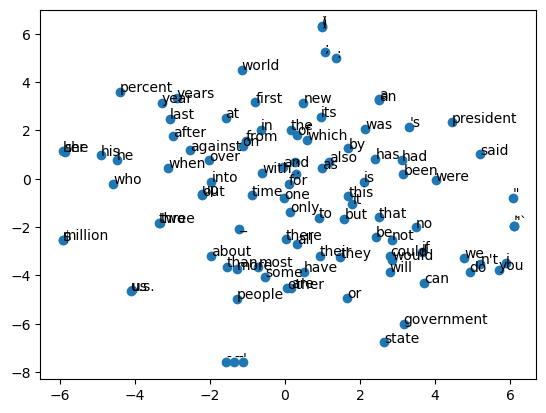

In [15]:

    tsne = TSNE(n_components=2, random_state=0)
    def plot_word_vectors(tokens, vectors):
        vectors = np.array(vectors)
        Y = tsne.fit_transform(vectors)
        plt.scatter(Y[:, 0], Y[:, 1])
        for label, x, y in zip(tokens, Y[:, 0], Y[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.show()


    tokens = list(embeddings_dict.keys())
    vectors = [embeddings_dict[token] for token in tokens]
    plot_word_vectors(tokens[:200],vectors[:100])



## Now let's try doing some vector math using the classic "king is to man as X is to woman" 

In [16]:

# do the classic vector addition
woman_king = embeddings_dict["king"] - embeddings_dict["man"] + embeddings_dict["woman"]
my_tokens = ["king", "man", "woman", "queen", "woman_king"]
my_vectors = [embeddings_dict["king"], embeddings_dict["man"], embeddings_dict["woman"], embeddings_dict["queen"], woman_king]



In [17]:
# see who the closest things in the embedding space are
print("Top 5 closest to  king - man + woman: ")
print(find_closest_embeddings(embeddings_dict["king"] - embeddings_dict["man"] + embeddings_dict["woman"])[:5])

print("Top 5 closest to  king: ")
print(find_closest_embeddings(embeddings_dict["king"])[:5])

print("Top 5 closest to  queen: ")
print(find_closest_embeddings(embeddings_dict["queen"])[:5])


Top 5 closest to  king - man + woman: 
['king', 'queen', 'daughter', 'prince', 'throne']
Top 5 closest to  king: 
['king', 'prince', 'queen', 'ii', 'emperor']
Top 5 closest to  queen: 
['queen', 'princess', 'lady', 'elizabeth', 'king']


## Now let's look at attention with a sentence of embeddings


In [18]:
def self_attention(vectors):
    """
    Implements a simple (no query, key value calculation) self attention on an n-length list
    of vectors. 
  
    Parameters
    ----------
    vectors : a list of real-valued vectors
 
    Returns
    -------
    an n-by-n array A where element A[i,j] contains the dot product of vectors[i] and vectors[j]
    """
    attention = np.zeros([len(vectors), len(vectors)])
    for i in range(len(vectors)):
        for j in range(len(vectors)):
            attention[i,j] = np.vdot(vectors[i],vectors[j])
    return attention


def show_self_attention(tokens, vectors, title = 'self attention'):
    """
    Calls self_attention(vectors) and visualizes it.
  
    Parameters
    ----------
    vectors : a list of real-valued vectors
    tokens : a list of string tokens where tokens[i] is the token for the embedding in vectors[i]
    title : the title for the plot
 
    Returns
    -------
    nothing
    """
    matrix = self_attention(vectors) 

    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    fig, ax = plt.subplots()
    min_val, max_val = 0, 5
    ax.matshow(matrix)

    ax.set_xlabel(tokens)
    plt.title(title)
    plt.show()

sentence_embeddings dimensions =  (9, 50)


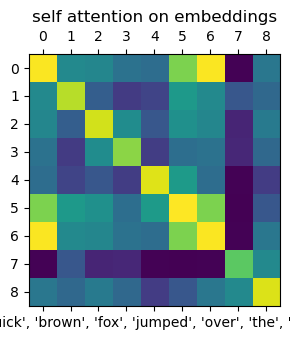

In [19]:
# here is a classic sentence
sentence_tokens = ["the", "quick", "brown", "fox", "jumped","over",  "the", "lazy","dog"]
sentence_embedings = [embeddings_dict[token] for token in sentence_tokens]
sentence_embedings = np.array(sentence_embedings)
print('sentence_embeddings dimensions = ', sentence_embedings.shape)
show_self_attention(sentence_tokens, sentence_embedings, 'self attention on embeddings')

## Now let's implement and view some absolute positional encoding

In [20]:
import math
def make_positional_encoding(number_of_tokens = 512, number_of_embedding_dimensions = 50):
    """
    Implements the absolute positional encoding described in the Attention is All You Need paper.
    For each embedding dimensionality, we create a sinusoid of some period.
  
    Parameters
    ----------
    number_of_tokens : int
        The expected length of the sequence of tokens that you will positionally encode 
    number_of_embedding_dimensions : int
        How many dimensions the embedding of each token has
  
    Returns
    -------
    a number_of_tokens by number_of_embedding_dimensions matrix containing a sinusoid for each embedding dimension
    """
    pe = torch.zeros([number_of_tokens, number_of_embedding_dimensions])
    position = torch.arange(0, number_of_tokens).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, number_of_embedding_dimensions, 2) * -(math.log(10000.0) / number_of_embedding_dimensions))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.numpy()

positional_encodings dimensions =  (512, 50)


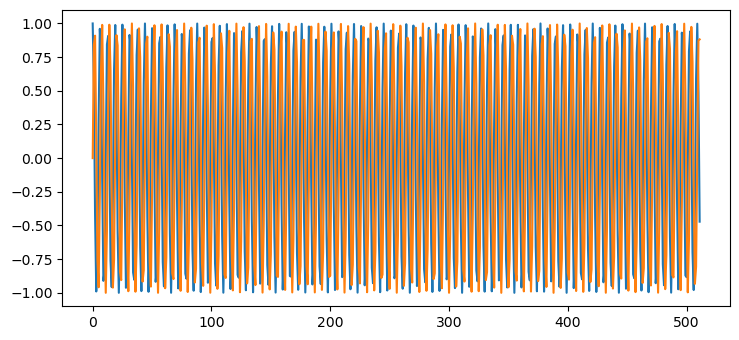

In [23]:

positional_encodings = make_positional_encoding(number_of_tokens = 512, number_of_embedding_dimensions=50)
print('positional_encodings dimensions = ', positional_encodings.shape)

# change the index numbers you see here to see different sinusoids
plt.plot(positional_encodings[:,1])
plt.plot(positional_encodings[:,0])
#plt.plot(positional_encodings[:,10])
#plt.plot(positional_encodings[:,11])


#### Now let's view attention, when applied just to positional encoding

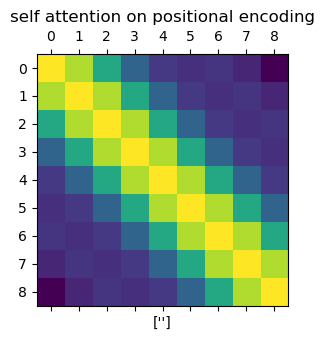

In [19]:
pe_tokens = [""]
number_of_tokens = 9
show_self_attention(pe_tokens, positional_encodings[:number_of_tokens,:], 'self attention on positional encoding')

## Now lets combine the positional encoding with the embeddings and apply self-attention

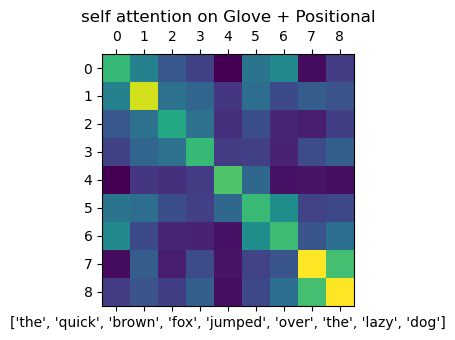

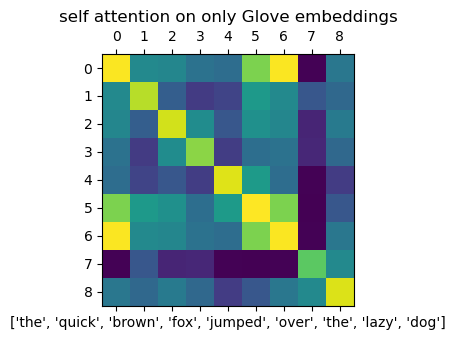

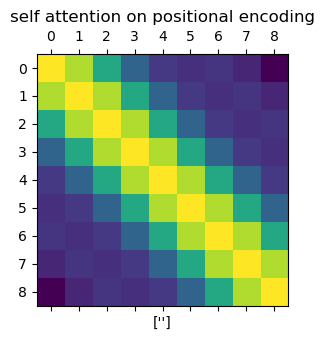

In [20]:
number_of_tokens_in_sentence = sentence_embedings.shape[0]
positional_sentence_embeddings = sentence_embedings + positional_encodings[:number_of_tokens_in_sentence,:]
show_self_attention(sentence_tokens,positional_sentence_embeddings, 'self attention on Glove + Positional')

show_self_attention(sentence_tokens, sentence_embedings, 'self attention on only Glove embeddings')

show_self_attention(pe_tokens, positional_encodings[:number_of_tokens_in_sentence,:], 'self attention on positional encoding')